# `mle-hyperopt`: Lightweight Hyperparameter Optimization 🚂
### Author: [@RobertTLange](https://twitter.com/RobertTLange) [Last Update: March 2023][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mle-infrastructure/mle-hyperopt/blob/main/examples/getting_started.ipynb)

Validating a simulation across a large range of parameters or tuning the hyperparameters of a neural network is common practice for every computational scientist. There are a plethora of open source tools that implement individual algorithms, but many of them are either combersome to set up and log or follow diverse syntax, which makes it hard to easily wrap them. For my personal research setup I wanted a simple API that allows me to generate batches of parameter configurations for various types of experiments and that comes with a set of handy features. These included the following: 

- **API simplicity**: The `mle-hyperopt` uses a simple interface alá `strategy.ask()` and `strategy.tell()`. Furthermore, many of the search spaces can be exported and repurposed. E.g. if you want to autovectorize/`jax.vmap` over a grid of parameters.
- **Strategy diversity**: While most hyperparameter tools implement the newest population-based search algorithms and Bayesian Optimization variants, often times they do not feature simple grid search. Even though [Bergstra and Bengio (2012)](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) showed that random search can be more efficient, often an intuitive understanding of a grey-box model can be enhanced by semi-exhaustive evaluation.
- **Interactive search space refinement**: After a certain set of search iterations, it can make sense to refine your search space boundaries based on the top performing configurations. This way the search can focus on a smaller range of promising configurations. This was for example done in [Schmidt et al. (2021)](https://arxiv.org/abs/2007.01547) and significantly improve computation efficient resource allocation. 
- **Exporting of configuration files**: Often times I want to submit a batch of training runs to a compute cluster (Slurm, etc.) and need to execute a downstream training routine that looks somewhat as follows: `python train.py --config_fname config.yaml`. In that case it is useful to have one script that executes calls to the cluster scheduler after having generated the configurations.
- **Storage and reloading of previous search logs**: I was astonished by how few libraries provide the simple utility of exporting and importing a previous search experiment for later continuation. E.g., in order to accomplish something similar in the FAIR's awesome [nevergrad](https://facebookresearch.github.io/nevergrad/) library, one has to write manual functionality that dumps the search log, reloads and supplies the previously stored results to a new search strategy instance.

And this was how the `mle-hyperopt` package was born. [***Note***: I by no means claim that this is something novel. Most likely you may your own substitute tool. But maybe you find a couple of the package's features useful. So hang in there 🤗] As of writing the package includes a set of diverse (e.g. single vs. multi-objective, model-free vs. model-based) search algorithms:

| | Search Type           | Description | `search_config` |
|----|----------------------- | ----------- | --------------- |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/grid.png?raw=true" alt="drawing" width="65"/>|  `GridSearch`          |  Search over list of discrete values  | - |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/random.png?raw=true" alt="drawing" width="65"/>|  `RandomSearch`        |  Random search over variable ranges         | `refine_after`, `refine_top_k` |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/coordinate.png?raw=true" alt="drawing" width="65"/>|  `CoordinateSearch`    |  Coordinate-wise optimization with fixed defaults | `order`, `defaults`
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/smbo.png?raw=true" alt="drawing" width="65"/>|  `SMBOSearch`          |  Sequential model-based optimization [(Hutter et al., 2011)](https://ml.informatik.uni-freiburg.de/wp-content/uploads/papers/11-LION5-SMAC.pdf)   | `base_estimator`, `acq_function`, `n_initial_points`
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/nevergrad.png?raw=true" alt="drawing" width="65"/>|  `NevergradSearch`     |  Multi-objective [nevergrad](https://facebookresearch.github.io/nevergrad/) wrapper | `optimizer`, `budget_size`, `num_workers`
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/halving.png?raw=true" alt="drawing" width="65"/>|  `HalvingSearch`     | Successive Halving [(Karmin et al., 2013)](https://proceedings.mlr.press/v28/karnin13.html) | `min_budget`, `num_arms`, `halving_coeff`
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/hyperband.png?raw=true" alt="drawing" width="65"/>|  `HyperbandSearch`     | Hyperband [(Li et al., 2018)](https://arxiv.org/pdf/1603.06560.pdf) | `max_resource`, `eta`
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/pbt.png?raw=true" alt="drawing" width="65"/>|  `PBTSearch`     | Population-Based Training [(Jaderberg et al., 2017)](https://arxiv.org/pdf/1711.09846.pdf) | `explore`, `exploit`

Each strategy implements a separate search space which one can sample from. The API follows the standard `ask`, `eval`, `tell` paradigm. The general package structure is summarized as follows:

<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/mle_hyperopt_structure.png?raw=true" alt="drawing" width="900"/>

In the remainder of this 'blog notebook' we will walk through the different features and use-cases. Let's start by implementing a small 'synthetic' helper function that evaluates the performance of a combination of 3 standard hyperparameters -- learning rate, batchsize and architecture:

In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

try:
    import mle_hyperopt
except:
    !pip install -q mle-hyperopt[examples]
    import mle_hyperopt

def fake_train(lrate, batch_size, arch):
    """Optimum: lrate=0.2, batch_size=4, arch='conv'."""
    f1 = ((lrate - 0.2) ** 2 + ((batch_size - 4)/4) ** 2
          + (0 if arch == "conv" else 0.2))
    return f1

## Basic API Usage: Grid Search <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/grid.png?raw=true" alt="drawing" width="50"/>

Imagine you simply want to loop over a discretized range of hyperparameters for our training surrogate. In order to do so we first need to define the search space. The `mle-hyperopt` package supports real-, integer- and categorically-valued parameters, whose ranges you specify via dictionaries. For real variables and integers you have to specifiy the beginning and end of the range (`begin`/`end`) as well as a prior (e.g. uniform or log-uniform) or the number of bins to discretize (`prior`/`bins`). For categorical variables simply supply a list of values:

| | Variable            | Type | Space Specification |
| --- |----------------------- | ----------- | --------------- |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/real.png?raw=true" alt="drawing" width="50"/> |  **`real`**          |  Real-valued  | `Dict`: `begin`, `end`, `prior`/`bins` (grid) |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/integer.png?raw=true" alt="drawing" width="50"/>  |  **`integer`**        |  Integer-valued         | `Dict`: `begin`, `end`, `prior`/`bins` (grid) |
|<img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/categorical.png?raw=true" alt="drawing" width="50"/> |  **`categorical`**  |  Categorical        | `List`: Values to search over

Let's now instantiate of search strategy for a range of learning rates and batch sizes as well as two network types we want to evaluate:

In [2]:
from mle_hyperopt import GridSearch

# Instantiate grid search class
strategy = GridSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "bins": 5}},
    integer={"batch_size": {"begin": 1, "end": 5, "bins": 1}},
    categorical={"arch": ["mlp", "cnn"]},
    verbose=True,
)

               MLE-Hyperopt Grid Hyperspace 🚀                         
                                                                                
           🌻 Variable   Type          Search Range ↔                           
          ───────────────────────────────────────────────────────────           
           arch          categorical   ['mlp', 'cnn']                           
           lrate         real          Begin: 0.1, End: 0.5, Bins: 5            
           batch_size    integer       Begin: 1, End: 5, Bins: 1     

[12:55:44] Start running 3D grid with 10 total configurations.      ]8;id=748486;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=280396;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#163\163]8;;\

If you set the verbosity option, the logged data will be printed to your console using the beautiful [rich](https://github.com/willmcgugan/rich) package. We are now ready to ask our search strategy for a set of proposal candidates:

In [3]:
# Ask the strategy for five configs to evaluate
configs = strategy.ask(batch_size=5)
configs

[{'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.30000000000000004},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.4},
 {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.5}]

Next, we can quickly evaluate our fake surrogate objective for the two proposal configurations and afterwards update the strategy with the collected data (e.g. a validation score). Note that the API assumes that we are minimizing an objective. If you want to instead maximize simply provide the option `maximize_objective = True` when instantiating the search strategy.

In [4]:
# Simple ask - eval - tell API
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ 
┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 12:55:48       ┃ 
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ 
│ Best Overall  │ 1  │ 0.762   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2 │ 
│ Best in Batch │ 1  │ 0.762   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2 │ 
└───────────────┴────┴─────────┴──────────────────────────────────────────────┘

The log with the individual search evaluation results can be stored and reloaded using `strategy.save()` and `strategy.load()`. You can store the strategy data as a json, yaml of pkl file.

In [5]:
# Storing of results to .json
strategy.save("search_log.json")

# Reloading of results from .json
strategy.load("search_log.json")

[12:55:51] Stored 5 search iterations ➞ search_log.json.                      ]8;id=133144;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=967994;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#354\354]8;;\

[12:55:51] {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1} was previously      ]8;id=994129;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=499359;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#261\261]8;;\
           evaluated.                                                                        

[12:55:51] {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2} was previously      ]8;id=186051;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=701540;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#261\261]8;;\
           evaluated.                                                                        

[12:55:51] {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.30000000000000004} was ]8;id=442154;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=395021;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#261\261]8;;\
           previously evaluated.                                                             

[12:55:51] {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.4} was previously      ]8;id=616219;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=10463;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#261\261]8;;\
           evaluated.                                                                        

[12:55:51] {'arch': 'mlp', 'batch_size': 1, 'lrate': 0.5} was previously      ]8;id=288773;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=372801;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#261\261]8;;\
           evaluated.                                                                        

[12:55:51] Reloaded 0 previous search iterations.                             ]8;id=465562;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=837607;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#416\416]8;;\

Note that no configuration is added to the log since they were already previously archived. This is different if we instatiate a new strategy with the `reload_path` option. In this case the new search strategy will load the previously stored log from the file:

In [6]:
from mle_hyperopt import GridSearch

strategy = GridSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "bins": 5}},
    integer={"batch_size": {"begin": 1, "end": 5, "bins": 1}},
    categorical={"arch": ["mlp", "cnn"]},
    reload_path="search_log.json",
)

[12:55:53] Reloaded 5 previous search iterations.                             ]8;id=931973;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py\strategy.py]8;;\:]8;id=833106;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategy.py#416\416]8;;\

There are different ways how you can access and analyse the search results:

- `strategy.log` will return the raw internal list of evaluation results.
- `strategy.df` will return the flattened log as a pandas dataframe.
- `strategy.get_best(top_k)` will retrieve the `top_k` best performing configurations.

But my two favorite tools are a plot of the best performance over search iterations and the overall ranking:

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

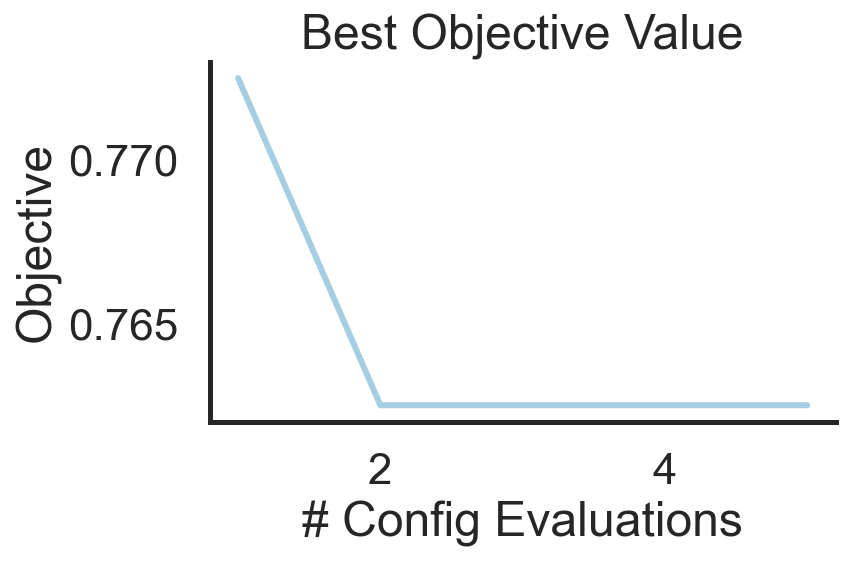

In [7]:
# Plot timeseries of best performing score over search iterations
strategy.plot_best()

In [8]:
# Print out ranking of best performers
strategy.print_ranking(top_k=4)

┏━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓    
   ┃ 🥇 Rank ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖                             ┃    
   ┡━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩    
   │ 1       │ 1  │ 0.762   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.2 │    
   │ 2       │ 0  │ 0.772   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.1 │    
   │ 3       │ 2  │ 0.772   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.3 │    
   │ 4       │ 3  │ 0.802   │ 'arch': 'mlp', 'batch_size': 1, 'lrate': 0.4 │    
   └─────────┴────┴─────────┴──────────────────────────────────────────────┘

In case you don't want to search over all configuration parameters, you can also add a dictionary of fixed parameters at instantiation (`fixed_params`). Additionally, you can also directly store the configurations as files by setting `store=True` (or also provide the filenames as a list using the `config_fnames` option). Below is an example for the case where we want to add a `momentum` parameter with value 0.9 to all configurations:

In [9]:
strategy = GridSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "bins": 5}},
    integer={"batch_size": {"begin": 1, "end": 5, "bins": 1}},
    categorical={"arch": ["mlp", "cnn"]},
    fixed_params={"momentum": 0.9},
)

strategy.ask(2, store=True)

([{'lrate': 0.1, 'arch': 'mlp', 'batch_size': 1, 'momentum': 0.9},
  {'lrate': 0.2, 'arch': 'mlp', 'batch_size': 1, 'momentum': 0.9}],
 ['eval_0.yaml', 'eval_1.yaml'])

## Random Search & Search Space Refinement <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/random.png?raw=true" alt="drawing" width="50"/>

Next let's see how we can define a random search strategy with priors over variables. As before we will define our search space using a set of dictionaries, but now the real and integer parameters will have a uniform or log-uniform prior placed over their range:

In [10]:
from mle_hyperopt import RandomSearch

strategy = RandomSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
    integer={"batch_size": {"begin": 1, "end": 5, "prior": "log-uniform"}},
    categorical={"arch": ["mlp", "cnn"]},
    search_config={"refine_after": 5, "refine_top_k": 2},
    seed_id=42,
    verbose=True,
)

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

                 MLE-Hyperopt Random Hyperspace 🚀                        
                                                                                
        🌻 Variable   Type          Search Range ↔                              
       ──────────────────────────────────────────────────────────────────       
        arch          categorical   ['mlp', 'cnn']                              
        lrate         real          Begin: 0.1, End: 0.5, Prior: uniform        
        batch_size    integer       Begin: 1, End: 5, Prior: log-uniform 

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 12:55:58        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 4  │ 0.268   │ 'arch': 'cnn', 'lrate': 0.123, 'batch_size':  │
│               │    │         │ 3                                             │
│ Best in Batch │ 4  │ 0.268   │ 'arch': 'cnn', 'lrate': 0.123, 'batch_size':  │
│               │    │         │ 3                                             │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

         MLE-Hyperopt Random - 5 Evals - Top 2 - Refined Hyperspace 🚀          
                                                                                
  🌻 Variable   Type          Search Range ↔                                    
 ────────────────────────────────────────────────────────────────────────────── 
  arch          categorical   ['cnn', 'mlp']                                    
  lrate         real          Begin: 0.123, End: 0.34044600469728353, Prior:    
                              uniform                                           
  batch_size    integer       Begin: 3, End: 3, Prior: log-uniform             

In the random search instantiation above we have additionally set the random seed for reproducibility and supplied a `search_config` dictionary with two keys: `refine_after` and `refine_top_k`. These two define when and how the search space will be contracted. More specifically, the ranges and categorical values will be altered to only include those of the top-k best performing configurations stored in the strategy log. This allows the strategy to spend more time sampling from regions of the search space, which have proven well-performing.

## SMBO <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/smbo.png?raw=true" alt="drawing" width="50"/> & Coordinate-Wise Search <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/coordinate.png?raw=true" alt="drawing" width="50"/>

The `mle-hyperopt` package also wraps around the [`scikit-optimize`](https://scikit-optimize.github.io/stable/index.html) API and provides a simple interface for SMBO ([Hutter et al., 2011](https://ml.informatik.uni-freiburg.de/wp-content/uploads/papers/11-LION5-SMAC.pdf)). You can customize the optimizer object with the `search_config` options. This includes different surrogate models ("GP", "RF", "ET", "GBRT") and acquisition functions ("LCB", "EI", "PI") as well as random initial seeding configurations. For more information check out the scikit optimizer [documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html#skopt.Optimizer).

In [11]:
from mle_hyperopt import SMBOSearch

strategy = SMBOSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
    integer={"batch_size": {"begin": 1, "end": 5, "prior": "uniform"}},
    search_config={
        "base_estimator": "GP",
        "acq_function": "gp_hedge",
        "n_initial_points": 5,
    },
    fixed_params={"arch": "cnn"},
)

configs = strategy.ask(5)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

Furthermore, I also implemented a more heuristic search, which I often would implement manually: We start by scanning one parameter and hold the other considered parameters fixed to a pre-specified `defaults` value. Afterwards, the previously scanned parameter is in turn fixed to its best value and we go over to the next parameter. We repeat this coordinate-wise search until all specified parameters are completed. The order in which we search over the variables is specified in the `search_config`.

In [12]:
from mle_hyperopt import CoordinateSearch

strategy = CoordinateSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "bins": 5}},
    integer={"batch_size": {"begin": 1, "end": 5, "bins": 5}},
    categorical={"arch": ["mlp", "cnn"]},
    search_config={
        "order": ["lrate", "batch_size", "arch"],
        "defaults": {"lrate": 0.1, "batch_size": 3, "arch": "mlp"},
    },
    verbose=True,
)

configs = strategy.ask(5)
configs

[12:56:01] New active variable/coordinate `lrate`.                          ]8;id=417868;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py\coordinate.py]8;;\:]8;id=955618;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py#163\163]8;;\

            MLE-Hyperopt Coordinate Hyperspace 🚀                      
                                                                                
           🌻 Variable   Type          Search Range ↔                           
          ───────────────────────────────────────────────────────────           
           batch_size    categorical   [3]                                      
           arch          categorical   ['mlp']                                  
           lrate         real          Begin: 0.1, End: 0.5, Bins: 5 

[{'arch': 'mlp', 'batch_size': 3, 'lrate': 0.1},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.2},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.30000000000000004},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.4},
 {'arch': 'mlp', 'batch_size': 3, 'lrate': 0.5}]

In [13]:
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ 
┃ 📥 Total: 5   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 12:56:02       ┃ 
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ 
│ Best Overall  │ 1  │ 0.262   │ 'arch': 'mlp', 'batch_size': 3, 'lrate': 0.2 │ 
│ Best in Batch │ 1  │ 0.262   │ 'arch': 'mlp', 'batch_size': 3, 'lrate': 0.2 │ 
└───────────────┴────┴─────────┴──────────────────────────────────────────────┘

[12:56:02] Fixed `lrate` hyperparameter to 0.2.                             ]8;id=537618;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py\coordinate.py]8;;\:]8;id=481075;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py#158\158]8;;\

[12:56:02] New active variable/coordinate `batch_size`.                     ]8;id=88929;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py\coordinate.py]8;;\:]8;id=406873;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py#163\163]8;;\

In [14]:
configs = strategy.ask(4)
values = [fake_train(**c) for c in configs]
strategy.tell(configs, values)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ 
┃ 📥 Total: 9   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 12:56:02       ┃ 
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ 
│ Best Overall  │ 7  │ 0.2     │ 'arch': 'mlp', 'batch_size': 4, 'lrate': 0.2 │ 
│ Best in Batch │ 7  │ 0.2     │ 'arch': 'mlp', 'batch_size': 4, 'lrate': 0.2 │ 
└───────────────┴────┴─────────┴──────────────────────────────────────────────┘

[12:56:02] Fixed `batch_size` hyperparameter to 4.                          ]8;id=241043;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py\coordinate.py]8;;\:]8;id=931582;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py#158\158]8;;\

[12:56:02] New active variable/coordinate `arch`.                           ]8;id=701366;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py\coordinate.py]8;;\:]8;id=193043;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/strategies/coordinate.py#163\163]8;;\

In [15]:
configs = strategy.ask()
values = fake_train(**configs)
strategy.tell(configs, values)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓ 
┃ 📥 Total: 10  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 12:56:03       ┃ 
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩ 
│ Best Overall  │ 7  │ 0.2     │ 'arch': 'mlp', 'batch_size': 4, 'lrate': 0.2 │ 
│ Best in Batch │ 9  │ 0.2     │ 'arch': 'cnn', 'batch_size': 4, 'lrate': 0.2 │ 
└───────────────┴────┴─────────┴──────────────────────────────────────────────┘

(<Figure size 432x288 with 1 Axes>,
 <Axes: title={'center': 'Best Objective Value'}, xlabel='# Config Evaluations', ylabel='Objective'>)

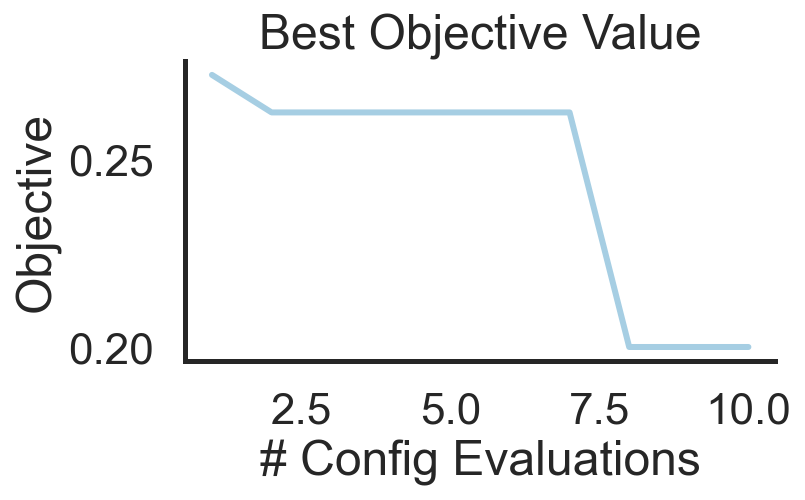

In [16]:
strategy.plot_best()

## Multi-Objective Hyperparameter Optimization with `nevergrad` <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/nevergrad.png?raw=true" alt="drawing" width="50"/>

So far we have discussed a set of single objective hyperparameter search strategies. But how about cases where we are interested in more than one objective? E.g. test accuracy and inference time. For these cases and for even more diverse search strategies we wrap around the `nevergrad` library by Facebook Research. 

In [17]:
def multi_fake_train(lrate, batch_size, arch):
    # optimal for learning_rate=0.2, batch_size=4, architecture="conv"
    f1 = (lrate - 0.2) ** 2 + (batch_size - 4) ** 2 + (0 if arch == "conv" else 10)
    # optimal for learning_rate=0.3, batch_size=2, architecture="mlp"
    f2 = (lrate - 0.3) ** 2 + (batch_size - 2) ** 2 + (0 if arch == "mlp" else 5)
    return f1, f2

In [18]:
from mle_hyperopt import NevergradSearch

strategy = NevergradSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
    integer={"batch_size": {"begin": 1, "end": 5, "prior": "uniform"}},
    search_config={"optimizer": "NGOpt", "budget_size": 100, "num_workers": 5},
    fixed_params={"arch": "cnn"},
)

configs = strategy.ask(5)
values = [multi_fake_train(**c) for c in configs]
strategy.tell(configs, values)
strategy.log

[{'eval_id': 0,
  'params': {'lrate': 0.3, 'batch_size': 4},
  'objective': (10.01, 9.0)},
 {'eval_id': 1,
  'params': {'lrate': 0.2890150583350444, 'batch_size': 4},
  'objective': (10.007923680610391, 9.000120668943381)},
 {'eval_id': 2,
  'params': {'lrate': 0.2644171178765383, 'batch_size': 2},
  'objective': (14.004149565075519, 5.001266141500212)},
 {'eval_id': 3,
  'params': {'lrate': 0.3768394539854681, 'batch_size': 3},
  'objective': (11.03127219248588, 6.005904301688785)},
 {'eval_id': 4,
  'params': {'lrate': 0.3, 'batch_size': 3},
  'objective': (11.01, 6.0)}]

In [19]:
strategy.print_ranking()

┏━━━━━━━━━┳━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓      
      ┃ 🥇 Rank ┃ ID ┃ Obj. 📉         ┃ Configuration 🔖                ┃      
      ┡━━━━━━━━━╇━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩      
      │ 1       │ -  │ [10.008, 9.0]   │ 'lrate': 0.289, 'batch_size': 4 │      
      │ 2       │ -  │ [10.01, 9.0]    │ 'lrate': 0.3, 'batch_size': 4   │      
      │ 3       │ -  │ [11.01, 6.0]    │ 'lrate': 0.3, 'batch_size': 3   │      
      │ 4       │ -  │ [14.004, 5.001] │ 'lrate': 0.264, 'batch_size': 2 │      
      └─────────┴────┴─────────────────┴─────────────────────────────────┘

# `hyperopt` decorator - minimal search wrapper

For convenience I also added a simple `hyperopt` function decorator, which allows you to automatically execute the search procedure loop. The decorator assumes that the function to evaluate directly consumes a configuration dictionary:

In [20]:
from mle_hyperopt import hyperopt


@hyperopt(
    strategy_type="Grid",
    num_search_iters=400,
    real={
        "x": {"begin": -0.5, "end": 0.5, "bins": 20},
        "y": {"begin": -0.5, "end": 0.5, "bins": 20},
    },
)
def circle_objective(config):
    distance = abs((config["x"] ** 2 + config["y"] ** 2))
    return distance


strategy = circle_objective()
len(strategy)

400

Additionally you can plot the results of any grid search as follows:

[-0.5        -0.44736842 -0.39473684 -0.34210526 -0.28947368 -0.23684211
 -0.18421053 -0.13157895 -0.07894737 -0.02631579  0.02631579  0.07894737
  0.13157895  0.18421053  0.23684211  0.28947368  0.34210526  0.39473684
  0.44736842  0.5       ] [-0.5        -0.44736842 -0.39473684 -0.34210526 -0.28947368 -0.23684211
 -0.18421053 -0.13157895 -0.07894737 -0.02631579  0.02631579  0.07894737
  0.13157895  0.18421053  0.23684211  0.28947368  0.34210526  0.39473684
  0.44736842  0.5       ]
20
20


(<Figure size 720x576 with 2 Axes>,
 <Axes: title={'center': 'Quadratics for Life\nHow beautiful can they be?'}, xlabel='x', ylabel='y'>)

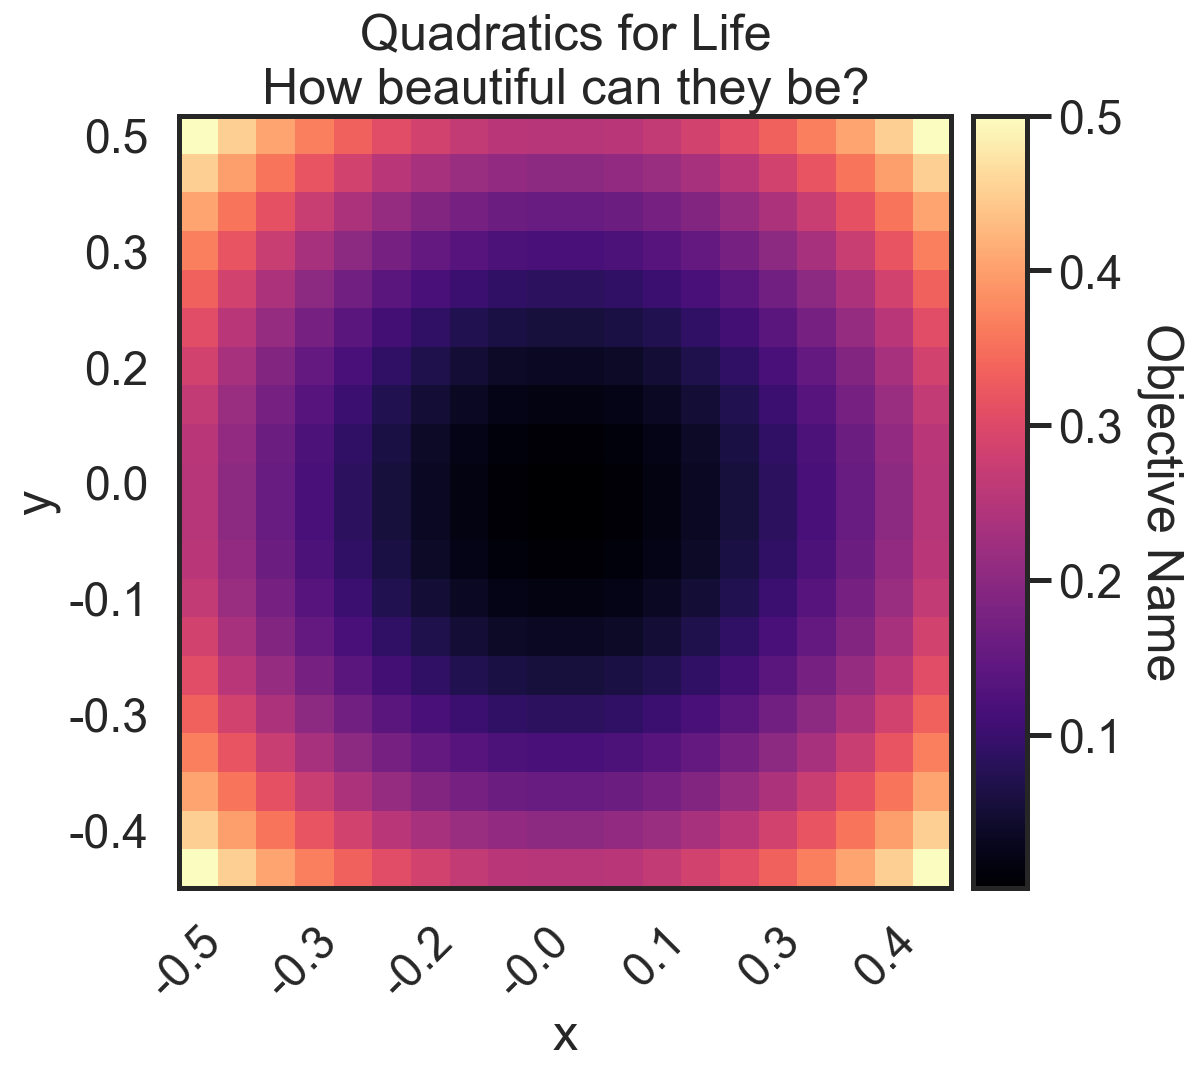

In [21]:
strategy.plot_grid(
    params_to_plot=["x", "y"],
    target_to_plot="objective",
    plot_title="Quadratics for Life",
    plot_subtitle="How beautiful can they be?",
    xy_labels=["x", "y"],
    variable_name="Objective Name",
    every_nth_tick=3,
)

If there are more than two search variables please additionally provide a `fixed_params` dictionary specifying the variable name and value to fix it to in the plot.

# Integration with `mle-logging` <img src="https://github.com/mle-infrastructure/mle-logging/blob/main/docs/logo_transparent.png?raw=true" alt="drawing" width="50"/> & `mle-scheduler` <img src="https://github.com/mle-infrastructure/mle-scheduler/blob/main/docs/logo_transparent.png?raw=true" alt="drawing" width="50"/>

In [22]:
try:
    from mle_logging import MLELogger
except:
    !pip install -q mle-logging
    from mle_logging import MLELogger

The `mle-hyperopt` package also smoothly integrates with the [`mle-logging`](https://github.com/mle-infrastructure/mle-logging) package, which can be leveraged to log training statistics, checkpoints and other objects of interest. You can simply store the configurations and provide the configuration filename as an input to the `MLELogger`. The logger will then load the configuration and copy it to the logging directory:

In [23]:
# Store a set of configurations
strategy = GridSearch(
    real={"lrate": {"begin": 1e-08, "end": 1e-06, "bins": 10}}, verbose=True
)
configs, config_fnames = strategy.ask(3, store=True)

# Instantiate logging to experiment_dir & pass configuration path
log = MLELogger(
    time_to_track=["num_updates", "num_epochs"],
    what_to_track=["train_loss", "test_loss"],
    experiment_dir="experiment_dir/",
    config_fname=config_fnames[0],
    use_tboard=False,
    model_type="torch",
)

log.update(
    {"num_updates": 1, "num_epochs": 1},
    {"train_loss": 0.1, "test_loss": 0.15},
    save=True,
)

# Check loaded and copied configuration
log.config_dict

              MLE-Hyperopt Grid Hyperspace 🚀                         
                                                                                
            🌻 Variable   Type   Search Range ↔                                 
           ─────────────────────────────────────────────────────────            
            lrate         real   Begin: 1e-08, End: 1e-06, Bins: 10 

[12:56:20] Start running 1D grid with 10 total configurations.      ]8;id=661622;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=253133;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#163\163]8;;\

{'lrate': 1e-08}

Furthermore, we can use the `mle-scheduler` package to directly execute the training script and aggregate `MLELogger` logs across multiple seeds. Below we train the weights of a small quadratic in PyTorch for multiple configurations in parallel:

In [26]:
try:
    from mle_scheduler import MLEQueue
except:
    !pip install -q mle-scheduler
    from mle_scheduler import MLEQueue
    
# Check if code is run in Colab: If so -- download py script from repo
try:
    import google.colab
    IN_COLAB = True
    !wget https://raw.githubusercontent.com/mle-infrastructure/mle-hyperopt/main/examples/iter_search/train_mlp.py
    path_to_exec = "train_mlp.py"
except:
    IN_COLAB = False
    path_to_exec = "iter_search/train_mlp.py"

In [29]:
queue = MLEQueue(
    resource_to_run="local",
    job_filename=path_to_exec,
    config_filenames=config_fnames,
    experiment_dir="logs",
    automerge_configs=True,
)
queue.run()

scores = [queue.log[r].stats.loss.mean[-1] for r in queue.mle_run_ids]
# You can also `tell` the strategy where you store the model ckpts
ckpts = [queue.log[r].meta.model_ckpt for r in queue.mle_run_ids]
strategy.tell(configs, scores, ckpts)

Output()

/Users/rob/anaconda3/envs/mle-toolbox/lib/python3.9/site-packages/numpy/lib/function_base.py:4650: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 3   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:00:56        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 2  │ 17.157  │ 'lrate': 0.0, 'ckpt':                         │
│               │    │         │ 'logs/eval_2/models/final/final_seed_0.pt'    │
│ Best in Batch │ 2  │ 17.157  │ 'lrate': 0.0, 'ckpt':                         │
│               │    │         │ 'logs/eval_2/models/final/final_seed_0.pt'    │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

# Advanced Search Strategies with Checkpoint Bookkeeping

Until now all of the introduced search strategies rely on the full evaluation of a training run. Afterwards, we provide the strategy with the batch of perfomances for the different configurations and move on to the next batch -- that starts to train from scratch. Alternatively, there are different techniques, which make use of the iterative nature of most training procedures (e.g. anything gradient descent based). These training runs can easily be interrupted and either terminated or continued based on their performance up to now. Thereby, it is possible to allocate compute resources more efficiently by focussing on more promising candidates, while early stopping of bad ones. Importantly, this requires us to keep track of the checkpoints/network states of our different runs. Next we will have a look at the three most popular algorithms of that nature which are implemented in `mle-hyperopt`.

## Successive Halving <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/halving.png?raw=true" alt="drawing" width="50"/>

Successive Halving (SH), first proposed by [(Karmin et al., 2013)](https://proceedings.mlr.press/v28/karnin13.html), is a simple strategy which originated in the context of finding the best arm in a multi-arm bandit setting. Given a set of potential arms, `num_arms`, one starts by evaluating all of them for a limited number of pulls. Afterwards, the worst arms are discarded and one continues evaluating the best ones for more pulls. This process continues and we discard more and more arms, while spending more and more pulls on the most promising arms.

In the context of tuning neural networks, the number of considered arms corresponds to the different configurations we are interested in evaluating. These can for example be randomly sampled. A "pull" from an arm then is analogous to training the network-configuration pair for a couple of steps. The aggressiveness with which we discard configurations is a hyperparameter (`halving_coeff`) and trades off **how many** configurations we can evaluate for **how long**. Finally, the strategy takes as an input the minimal number of pulls from all arms: `min_budget`. Let us again define a surrogate objective, which is "iterative" in its nature (taking `epoch` as an input):

In [30]:
import numpy as np


def get_iteration_score(
    epoch: int, seed_id: int, lrate: float, batch_size: int, arch: str, **kwargs
) -> (float, float):
    """Surrogate Objective w. optimum: lrate=0.2, batch_size=4, arch='conv'."""
    f1 = (lrate - 0.2) ** 2 + (batch_size - 4) ** 2 + (0 if arch == "conv" else 10)
    train_loss = f1 + seed_id * 0.5
    test_loss = f1 + seed_id * 0.5 + np.random.uniform(0, 0.3)
    return train_loss / epoch, test_loss / epoch

Next, we instantiate the search class with a given set of hyperparameters. During the first `ask` call 20 configurations will be randomly sampled from the search space. Setting `halving_coeff` to 2 implies that at each `tell` call 50% of the still considered configurations will be discarded and that the amount of step iterations for the remaining ones is doubled:

In [31]:
from mle_hyperopt import HalvingSearch

strategy = HalvingSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
    integer={"batch_size": {"begin": 1, "end": 5, "prior": "log-uniform"}},
    categorical={"arch": ["mlp", "cnn"]},
    search_config={"min_budget": 1, "num_arms": 20, "halving_coeff": 2},
    seed_id=42,
    verbose=True,
)

                 MLE-Hyperopt Halving Hyperspace 🚀                       
                                                                                
        🌻 Variable   Type          Search Range ↔                              
       ──────────────────────────────────────────────────────────────────       
        arch          categorical   ['mlp', 'cnn']                              
        lrate         real          Begin: 0.1, End: 0.5, Prior: uniform        
        batch_size    integer       Begin: 1, End: 5, Prior: log-uniform 

[13:01:07] Start running 5 batches of Successive Halving.           ]8;id=812109;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=680980;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#186\186]8;;\

           ➞ Configurations per batch: [20, 10, 5, 2, 1]            ]8;id=707594;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=673744;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#189\189]8;;\

           ➞ Iterations per batch: [1, 2, 4, 8, 16]                 ]8;id=809262;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=769056;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#190\190]8;;\

           ➞ Halving coefficient: 2                                 ]8;id=925795;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=106955;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#191\191]8;;\

           ➞ Total Number of Iterations: 92                         ]8;id=225188;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=774092;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#192\192]8;;\

           ➞ Batch No. 1/5: 20 configs for 1 iters.                 ]8;id=736925;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=59646;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#193\193]8;;\

In [32]:
configs = strategy.ask()
scores = [
    get_iteration_score(c["extra"]["sh_num_total_iters"], 0, **c["params"])[1]
    for c in configs
]
ckpts = [f"ckpt_0_{i}.pt" for i in range(len(configs))]
strategy.tell(configs, scores, ckpts)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 20  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:23        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 13 │ 10.185  │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_0_13.pt'                     │
│ Best in Batch │ 13 │ 10.185  │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_0_13.pt'                     │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:23] Completed 1/5 batches of SH ➢ 20/92 iters.               ]8;id=450320;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=207034;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#221\221]8;;\

           ➞ Next - Batch No. 2/5: 10 configs for 2 iters.          ]8;id=258589;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=702177;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#226\226]8;;\

We want to be able to keep track of the previously trained checkpoints. If a configuration "survives" we can amortize the previous training steps by reloading the old checkpoint and only train for the remaining additional step. The corresponding configurations therefore have a different structure, which allows to access the checkpoint via `extra`-> `sh_ckpt`:

In [33]:
configs = strategy.ask()
print(configs[0])
scores = [
    get_iteration_score(c["extra"]["sh_num_total_iters"], 0, **c["params"])[1]
    for c in configs
]
ckpts = [f"ckpt_1_{i}.pt" for i in range(len(configs))]
strategy.tell(configs, scores, ckpts)

{'params': {'arch': 'cnn', 'lrate': 0.48, 'batch_size': 4}, 'extra': {'sh_num_total_iters': 2, 'sh_num_add_iters': 1, 'sh_counter': 1, 'sh_ckpt': 'ckpt_0_13.pt'}}



┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 30  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:25        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 20 │ 5.155   │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_1_0.pt'                      │
│ Best in Batch │ 20 │ 5.155   │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_1_0.pt'                      │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:25] Completed 2/5 batches of SH ➢ 40/92 iters.               ]8;id=504502;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=311393;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#221\221]8;;\

           ➞ Next - Batch No. 3/5: 5 configs for 4 iters.           ]8;id=377179;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=115938;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#226\226]8;;\

Another point worth noting is that you can arbitrarily redefine the amount of GD steps which equal one SH iteration for your application at hand. For such a more realistic example which trains a small MLP, I recommend to check out this [example script](https://github.com/mle-infrastructure/mle-hyperopt/blob/main/examples/run_sh_mlp.py).

## Hyperband <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/hyperband.png?raw=true" alt="drawing" width="50"/>

Hyperband [(Li et al., 2018)](https://arxiv.org/pdf/1603.06560.pdf) provides an extension to Successive Halving. In SH it is not apriori clear whether we would like to evaluate a small set of configurations for many iterations or instead explore many of them for only a few iterations. You as a designer have to tune the trade-off. Hyperband tries to overcome this problem by calling SH as an inner loop for different trade-off settings. Simply put: Hyperband runs many SH loops with different hyper-hyperparameters. You only have to set the maximal number of iterations that can be prescribed to any single run (`max_resource`) and the having aggressivity (`eta`). That's all.


In [34]:
from mle_hyperopt import HyperbandSearch

strategy = HyperbandSearch(
    real={"lrate": {"begin": 0.1, "end": 0.5, "prior": "uniform"}},
    integer={"batch_size": {"begin": 1, "end": 5, "prior": "log-uniform"}},
    categorical={"arch": ["mlp", "cnn"]},
    search_config={"max_resource": 27, "eta": 3},
    seed_id=42,
    verbose=True,
)

                MLE-Hyperopt Hyperband Hyperspace 🚀                      
                                                                                
        🌻 Variable   Type          Search Range ↔                              
       ──────────────────────────────────────────────────────────────────       
        arch          categorical   ['mlp', 'cnn']                              
        lrate         real          Begin: 0.1, End: 0.5, Prior: uniform        
        batch_size    integer       Begin: 1, End: 5, Prior: log-uniform 

[13:01:27] Start running 11 batches of Hyperband evaluations.       ]8;id=790308;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=906044;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#250\250]8;;\

           ➞ Evals per batch: [27, 9, 3, 1, 9, 3, 1, 6, 2, 4, 1]    ]8;id=732274;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=843156;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#253\253]8;;\

           ➞ Total SH loops: 4 | Arms per loop: [27, 9, 6, 4]       ]8;id=733989;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=214082;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#254\254]8;;\

           ➞ Min. budget per loop: [1, 3, 9, 27]                    ]8;id=994303;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=826236;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#257\257]8;;\

           ➞ Start Loop No. 1/4: 27 arms & 1 min budget.            ]8;id=137769;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=3243;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#258\258]8;;\

In [35]:
configs = strategy.ask()
scores = [
    get_iteration_score(c["extra"]["sh_num_total_iters"], 0, **c["params"])[1]
    for c in configs
]
ckpts = [f"ckpt_2_{i}.pt" for i in range(len(configs))]
strategy.tell(configs, scores, ckpts)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 27  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:27        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 13 │ 10.333  │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_2_13.pt'                     │
│ Best in Batch │ 13 │ 10.333  │ 'arch': 'cnn', 'lrate': 0.48, 'batch_size':   │
│               │    │         │ 4, 'ckpt': 'ckpt_2_13.pt'                     │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:27] Completed 1/11 of Hyperband evaluation batches.          ]8;id=619858;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=371824;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#285\285]8;;\

           ➞ Done with 0/4 loops of SH.                             ]8;id=103073;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=487971;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#289\289]8;;\

           ➞ Active Loop No. 1/4: 27 arms & 1 min budget.           ]8;id=716260;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=86448;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#291\291]8;;\

           ➞ Next batch of SH: 9 evals.                             ]8;id=795379;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=868298;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#296\296]8;;\

## Population-Based Training <img src="https://github.com/mle-infrastructure/mle-hyperopt/blob/main/docs/pbt.png?raw=true" alt="drawing" width="50"/>

`mle-hyperopt` also implements Population-Based Training [(Jaderberg et al., 2017)](https://arxiv.org/pdf/1711.09846.pdf). In the following we replicate the toy example of figure 2 in the main paper. You can find a neural network example [here](https://github.com/mle-infrastructure/mle-hyperopt/blob/main/examples/run_pbt_mlp.py) with PyTorch training loop.

In [36]:
from mle_hyperopt import PBTSearch


class QuadraticProblem(object):
    def __init__(self, theta=None, lrate: float = 0.1):
        self.lrate = lrate

    def step(self, h, theta):
        """Perform GradAscent step on quadratic surrogate objective (max!)."""
        surrogate_grad = -2.0 * h * theta
        return theta + self.lrate * surrogate_grad

    def evaluate(self, theta):
        """Ground truth objective (e.g. val loss) - Jaderberg et al. 2016."""
        return 1.2 - np.sum(theta**2)

    def surrogate_objective(self, h, theta):
        """Surrogate objective (with hyperparams h) - Jaderberg et al. 2016."""
        return 1.2 - np.sum(h * theta**2)

    def __call__(self, theta, hyperparams):
        h = np.array([hyperparams["h0"], hyperparams["h1"]])
        theta = self.step(h, theta)
        exact = self.evaluate(theta)
        surrogate = self.surrogate_objective(h, theta)
        return theta.tolist(), exact


problem = QuadraticProblem()
ckpts = [[0.9, 0.9], [0.9, 0.9]]
value = [
    problem(ckpts[0], {"h0": 0.9, "h1": 0.9})[1],
    problem(ckpts[1], {"h0": 0.9, "h1": 0.9})[1],
]

theta_log = [ckpts]
value_log = [value]
steps_until_ready = 4

The exploration and exploitation strategies can be specified using the `explore`, `exploit` settings in the `search_config`.

In [37]:
strategy = PBTSearch(
    real={
        "h0": {"begin": 0.0, "end": 1.0, "prior": "uniform"},
        "h1": {"begin": 0.0, "end": 1.0, "prior": "uniform"},
    },
    search_config={
        "exploit": {"strategy": "truncation", "selection_percent": 0.2},
        "explore": {"strategy": "additive-noise", "noise_scale": 0.35},
        "steps_until_ready": 4,
        "num_workers": 2,
    },
    maximize_objective=True,
    verbose=True,
)

configs = strategy.ask()
configs[0]["params"]["h0"] = 0.1
configs[0]["params"]["h1"] = 0.9
configs[1]["params"]["h0"] = 0.9
configs[1]["params"]["h1"] = 0.1

               MLE-Hyperopt PBT Hyperspace 🚀                          
                                                                                
           🌻 Variable   Type   Search Range ↔                                  
          ───────────────────────────────────────────────────────────           
           h0            real   Begin: 0.0, End: 1.0, Prior: uniform            
           h1            real   Begin: 0.0, End: 1.0, Prior: uniform 

[13:01:32] Start running PBT w. 2 workers.                          ]8;id=795101;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=617236;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#316\316]8;;\

           ➞ Steps until ready: 4                                   ]8;id=757733;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=314991;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#317\317]8;;\

           ➞ Exploration strategy: additive-noise                   ]8;id=717287;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=769132;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#318\318]8;;\

           ➞ Exploitation strategy: truncation                      ]8;id=988681;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=524014;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#319\319]8;;\

In [38]:
for s in range(steps_until_ready):
    theta_l, value_l = [], []
    for i in range(len(configs)):
        theta, exact = problem(theta_log[-1][i], configs[i]["params"])
        theta_l.append(theta)
        value_l.append(exact)
    value_log.append(value_l)
    theta_log.append(theta_l)

ckpts = theta_log[-1]
values = value_log[-1]
strategy.tell(configs, values, ckpts)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 2   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:33        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 1  │ 0.345   │ 'h0': 0.9, 'h1': 0.1, 'ckpt':                 │
│               │    │         │ [0.40690958399999994, 0.8301313440000001]     │
│ Best in Batch │ 0  │ 0.345   │ 'h0': 0.1, 'h1': 0.9, 'ckpt':                 │
│               │    │         │ [0.8301313440000001, 0.40690958399999994]     │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:33] Completed 1 batches of PBT.                              ]8;id=485348;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=486140;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 4                               ]8;id=80456;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=10504;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 0.345) exploits W1 (P: 0.345)              ]8;id=792641;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=845373;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 0.9, 'h1': 0.1}                    ]8;id=136607;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=476349;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

           ➞ 👨‍🚒 W1 (P: 0.345) continues own trajectory.           ]8;id=817757;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=658658;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 0.9, 'h1': 0.1}                    ]8;id=972354;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=549072;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

Next we ask for the next set of PBT hyperparameters and the checkpoints to reload. Note that in our simple example we directly use the `theta` values as `pbt_ckpt`. In more realistic settings this will be a string that points you to the network checkpoint to reload. 

In [39]:
num_pbt_steps = 5
for t in range(num_pbt_steps):
    configs = strategy.ask()
    for s in range(steps_until_ready):
        theta_l, value_l = [], []
        for i in range(len(configs)):
            if s == 0:
                theta_log[-1][i] = configs[i]["extra"]["pbt_ckpt"]
            theta, exact = problem(theta_log[-1][i], configs[i]["params"])
            theta_l.append(theta)
            value_l.append(exact)
        value_log.append(value_l)
        theta_log.append(theta_l)

    ckpts = theta_log[-1]
    values = value_log[-1]
    strategy.tell(configs, values, ckpts)

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 4   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:36        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 3  │ 0.58    │ 'h0': 0.9, 'h1': 0.1, 'ckpt':                 │
│               │    │         │ [0.1839726772789478, 0.7656867203236071]      │
│ Best in Batch │ 3  │ 0.58    │ 'h0': 0.9, 'h1': 0.1, 'ckpt':                 │
│               │    │         │ [0.1839726772789478, 0.7656867203236071]      │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:36] Completed 2 batches of PBT.                              ]8;id=996250;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=534488;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 8                               ]8;id=408194;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=49160;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 0.491) exploits W1 (P: 0.58)               ]8;id=33803;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=886604;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 0.9, 'h1': 0.1}                    ]8;id=542870;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=55856;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

           ➞ 👨‍🚒 W1 (P: 0.58) continues own trajectory.            ]8;id=533984;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=142271;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 0.9, 'h1': 0.1}                    ]8;id=679483;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=939615;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 6   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:36        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 4  │ 0.88    │ 'h0': 1.453, 'h1': 0.369, 'ckpt':             │
│               │    │         │ [0.04660719817215214, 0.5636629049030013]     │
│ Best in Batch │ 4  │ 0.88    │ 'h0': 1.453, 'h1': 0.369, 'ckpt':             │
│               │    │         │ [0.04660719817215214, 0.5636629049030013]     │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:36] Completed 3 batches of PBT.                              ]8;id=536447;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=950952;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 12                              ]8;id=843592;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=419406;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 0.88) continues own trajectory.            ]8;id=354864;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=860645;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 1.453, 'h1': 0.369}                ]8;id=24094;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=380900;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

           ➞ 👨‍🚒 W1 (P: 0.694) exploits W0 (P: 0.88)               ]8;id=169271;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=841960;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 1.453, 'h1': 0.369}                ]8;id=445304;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=134783;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 8   ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:36        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 7  │ 1.077   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.014151865342057996, 0.35096096741021804]   │
│ Best in Batch │ 7  │ 1.077   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.014151865342057996, 0.35096096741021804]   │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:36] Completed 4 batches of PBT.                              ]8;id=611578;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=941975;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 16                              ]8;id=330472;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=348688;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 1.028) exploits W1 (P: 1.077)              ]8;id=602455;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=867852;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=424567;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=274332;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

           ➞ 👨‍🚒 W1 (P: 1.077) continues own trajectory.           ]8;id=900960;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=412664;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=658846;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=435078;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 10  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:36        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 9  │ 1.152   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.004297089301956946, 0.21852351746778978]   │
│ Best in Batch │ 9  │ 1.152   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.004297089301956946, 0.21852351746778978]   │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:36] Completed 5 batches of PBT.                              ]8;id=875588;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=185092;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 20                              ]8;id=668907;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=641299;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 1.136) exploits W1 (P: 1.152)              ]8;id=802405;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=579237;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=9616;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=256299;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

           ➞ 👨‍🚒 W1 (P: 1.152) continues own trajectory.           ]8;id=499242;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=919415;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=54641;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=947882;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

┏━━━━━━━━━━━━━━━┳━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ 📥 Total: 12  ┃ ID ┃ Obj. 📉 ┃ Configuration 🔖 - 03/08/2023 13:01:36        ┃
┡━━━━━━━━━━━━━━━╇━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Best Overall  │ 11 │ 1.181   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.0013047733300653084, 0.1360622180833011]   │
│ Best in Batch │ 11 │ 1.181   │ 'h0': 1.288, 'h1': 0.558, 'ckpt':             │
│               │    │         │ [0.0013047733300653084, 0.1360622180833011]   │
└───────────────┴────┴─────────┴───────────────────────────────────────────────┘

[13:01:36] Completed 6 batches of PBT.                              ]8;id=681084;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=25328;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#333\333]8;;\

           ➞ Number of total steps: 24                              ]8;id=923002;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=671174;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#334\334]8;;\

           ➞ 👨‍🚒 W0 (P: 1.143) exploits W1 (P: 1.181)              ]8;id=856725;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=962399;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#337\337]8;;\

           -- E/E Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=653489;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=163077;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#343\343]8;;\

           ➞ 👨‍🚒 W1 (P: 1.181) continues own trajectory.           ]8;id=694003;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=260808;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#345\345]8;;\

           -- Old Params: {'h0': 1.288, 'h1': 0.558}                ]8;id=964062;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py\comms.py]8;;\:]8;id=791631;file:///Users/rob/Dropbox/core-code/mle-infrastructure/mle-hyperopt/mle_hyperopt/utils/comms.py#350\350]8;;\

**Note**: The `theta` plot below is different from the one shown in the paper (figure 2). There are two potential reasons for this: 

1. We use a synchronous version of PBT, which waits until all workers have completed their 4 gradient descent steps. The original version is asynchronous and each worker writes its state to memory/a file system after each individual evaluation. Thereby slow workers can be pulled ahead by copying fast workers.
2. The difference between the sync and async PBT setting are more likely to have impact when there are many workers. The here observed differences are more likely due to the fact that the toy problem in Jaderberg et al. (2017) actually does not implement the proposed copying of the `h` hyperparameters before applying the exploration. Instead each worker only copies the `theta` state and keeps its own `h`. Afterwards, these are slightly perturbed. I assume the paper chose to do so as an educational/illustrative excercise, given that copying also `h` increases performance! 

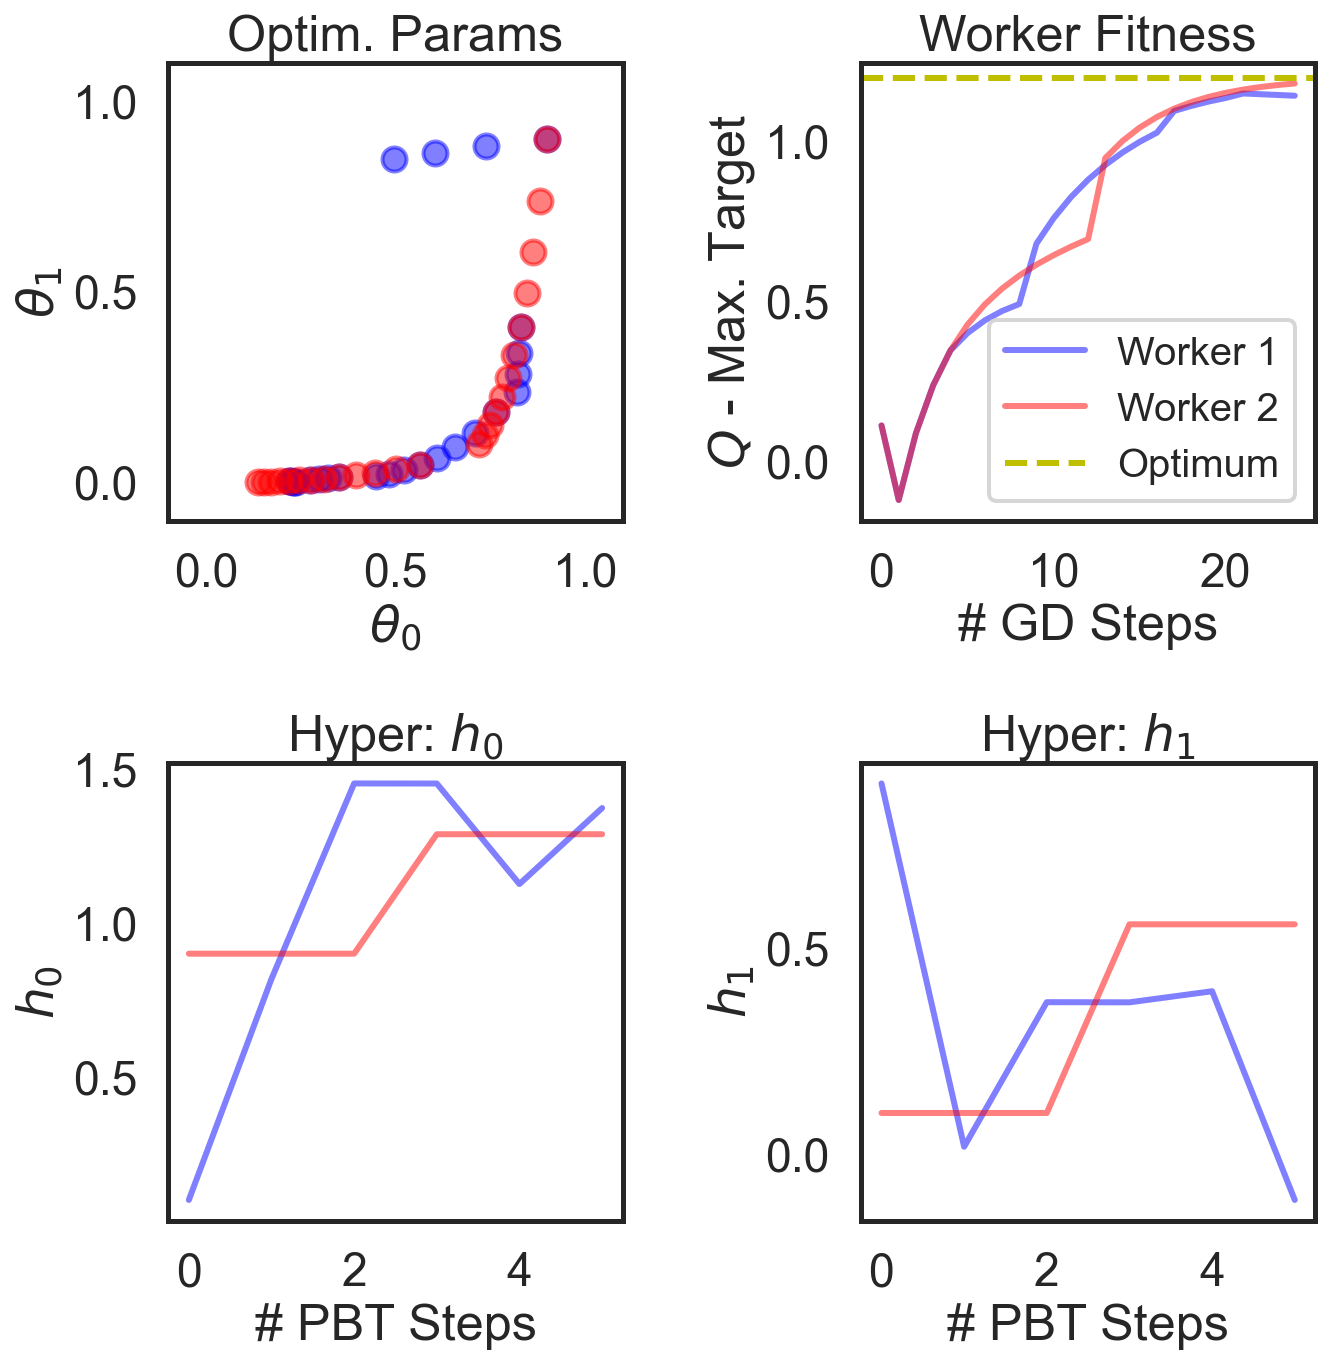

In [40]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs.flatten()[0].scatter(
    np.array(theta_log)[:, 0, 1],
    np.array(theta_log)[:, 0, 0],
    c="b",
    label="W-1",
    alpha=0.5,
)
axs.flatten()[0].scatter(
    np.array(theta_log)[:, 1, 1],
    np.array(theta_log)[:, 1, 0],
    c="r",
    label="W-2",
    alpha=0.5,
)
axs.flatten()[0].set_xlim(-0.1, 1.1)
axs.flatten()[0].set_ylim(-0.1, 1.1)
axs.flatten()[0].set_xlabel(r"$\theta_0$")
axs.flatten()[0].set_ylabel(r"$\theta_1$")
axs.flatten()[0].set_title("Optim. Params")

axs.flatten()[1].plot(np.array(value_log)[:, 0], c="b", label="Worker 1", alpha=0.5)
axs.flatten()[1].plot(np.array(value_log)[:, 1], c="r", label="Worker 2", alpha=0.5)
axs.flatten()[1].axhline(1.2, c="y", ls="--", label="Optimum")
axs.flatten()[1].set_xlabel("# GD Steps")
axs.flatten()[1].set_ylabel(r"$Q$ - Max. Target")
axs.flatten()[1].legend(fontsize=20)
axs.flatten()[1].set_title("Worker Fitness")

axs.flatten()[2].plot(
    strategy.df[strategy.df["pbt_worker_id"] == 0].h0.values,
    c="b",
    label="W-1",
    alpha=0.5,
)
axs.flatten()[2].plot(
    strategy.df[strategy.df["pbt_worker_id"] == 1].h0.values,
    c="r",
    label="W-2",
    alpha=0.5,
)
axs.flatten()[2].set_xlabel(r"# PBT Steps")
axs.flatten()[2].set_ylabel(r"$h_0$")
axs.flatten()[2].set_title(r"Hyper: $h_0$")

axs.flatten()[3].plot(
    strategy.df[strategy.df["pbt_worker_id"] == 0].h1.values,
    c="b",
    label="W-1",
    alpha=0.5,
)
axs.flatten()[3].plot(
    strategy.df[strategy.df["pbt_worker_id"] == 1].h1.values,
    c="r",
    label="W-2",
    alpha=0.5,
)
axs.flatten()[3].set_xlabel(r"# PBT Steps")
axs.flatten()[3].set_ylabel(r"$h_1$")
axs.flatten()[3].set_title(r"Hyper: $h_1$")
fig.tight_layout()

That's it! Give `mle-hyperopt` a try and let me know what you think! If you find a bug or are missing your favourite feature, feel free to contact me [@RobertTLange](https://twitter.com/RobertTLange) or create an issue!